In [17]:
import torch
import torchvision
from torchvision import transforms, datasets

train_data = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_data = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
  
                       ]))

trainset = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False)

- The torch.nn import gives us access to some helpful neural network things, such as various neural network layer types (things like regular fully-connected layers, convolutional layers (for imagery), recurrent layers...etc).

- The torch.nn.functional area specifically gives us access to some handy functions that we might not want to write ourselves. We will be using the relu or "rectified linear" activation function for our neurons.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() #Typically, when you inherit from a parent class, that init method doesn't actually get run. This is how we can run that init method of the parent class
        self.fc1 = nn.Linear(in_features=28*28, out_features= 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1) #dim=1 defines across which axis should the sum be 1. Since we have batch_size =10 and no. of labels also 10 (0 to 9). SO we would apply softmax across axis=1

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


So, our first layer takes in 28x28, because our images are 28x28 images of hand-drawn digits. A basic neural network is going to expect to have a flattened array, so not a 28x28, but instead a 1x784.

Then this outputs 64 connections. This means the next layer, fc2 takes in 64 (the next layer is always going to accept however many connections the previous layer outputs). From here, this layer ouputs 64, then fc3 just does the same thing.

In [20]:
# Cretae a random image
X = torch.randn((28,28))

In [21]:
#Flatten before feeding it to NN
X = X.view(-1,28*28)

You should understand the 28*28 part, but why the leading -1?

Any input and output to our neural network is expected to be a group feature sets.

Even if you intend to just pass 1 set of features, you still have to pass it as a "list" of features.

In our case, we really just want a 1x784, and we could say that, but you will more often is -1 used in these shapings. Why? -1 suggests "any size". So it could be 1, 12, 92, 15295...etc. It's a handy way for that bit to be variable. In this case, the variable part is how many "samples" we'll pass through.

In [22]:
output = net(X)
output

tensor([[-2.3274, -2.4268, -2.3198, -2.2927, -2.2916, -2.2836, -2.2275, -2.2084,
         -2.2677, -2.4013]], grad_fn=<LogSoftmaxBackward>)

In [23]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) #net.parameters() refers to everything that is trainable

In [24]:
EPOCHS = 3
for epoch in range(EPOCHS): # 3 full passes over the data
    for data in trainset:  # `data` is a batch of featuresets and labels
        X, y = data  # X is the batch of features, y is the batch of targets. So X[0] is the first image
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X.view(-1,28*28))  # pass in the reshaped batch (recall they are 28x28 atm)
        loss = F.nll_loss(output, y)  # since our label is a scaler value i.e 0 to 9 and not one-hot vector hence we used nll_loss. If labels were one-hot vector use MSE.
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(loss)  # print loss.  it only output the loss of the last batch of the data for each epoch

tensor(0.1138, grad_fn=<NllLossBackward>)
tensor(0.0010, grad_fn=<NllLossBackward>)
tensor(0.0308, grad_fn=<NllLossBackward>)


-  The output of the network is log of probability (due to F.log_softmax(x, dim=1)) so it is all negative and it doesn't sum up to 1, it sums up to a negative value. The training works out because we use the 'F.nll_loss(output,y)' which is the negative log likelihood loss and it requires the inputs exactly we have provided them, where the output is log probabilities of each class and the labels are just a class index. (0,1,2,3...)

- Once we pass data through our neural network, getting an output, we can compare that output to the desired output. With this, we can compute the gradients for each parameter, which our optimizer (Adam, SGD...etc) uses as information for updating weights.

This is why it's important to do a net.zero_grad() for every step, otherwise these gradients will add up for every pass, and then we'll be re-optimizing for previous gradients that we already optimized for.

In [25]:
correct = 0
total = 0

with torch.no_grad(): #Don't upadte the weights while passing this time while passing the data through NN
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.965


- "model.train()" and "model.eval()" activates and deactivates Dropout and BatchNorm, so it is quite important. "with torch.no_grad()" only deactivates gradient calculations, but doesn't turn off Dropout and BatchNorm. Your model accuracy will therefore be lower if you don't use model.eval() when evaluating the model.
- If you want to evaluate your model on the test set, you should use "model.eval()" to get the real accuracy and also use "with torch.no_grad()" at the same time to avoid calculating the gradients, which saves time (During evaluation you are not optimizing your model, so you don't need to calculate gradients).

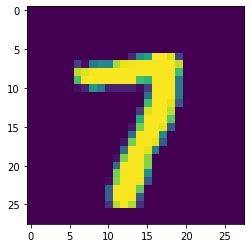

In [26]:
import matplotlib.pyplot as plt

plt.imshow(X[0].view(28,28))
plt.show()

In [27]:
print(torch.argmax(net(X[0].view(-1,784))[0]))

tensor(7)


In [ ]:
#Breakdown of above code
a_featureset = X[0]
reshaped_for_network = a_featureset.view(-1,784) # 784 b/c 28*28 image resolution.
output = net(reshaped_for_network) #output will be a list of network predictions.
first_pred = output[0]
print(first_pred)
biggest_index = torch.argmax(first_pred)
print(biggest_index)